In [1]:
import sys
sys.path.append("/fs/clip-controllablemt/IWSLT2022/scripts")

In [2]:
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer
)
import torch

In [3]:
def read_file(fname):
    data = []
    with open(fname) as f:
        for line in f:
            data.append(line.strip())
    return data

def get_data(tgt_lang, domain, split):
    source = read_file(f"../internal_split/en-{tgt_lang}/{split}.{domain}.en")
    formal_translations = read_file(f"../internal_split/en-{tgt_lang}/{split}.{domain}.formal.{tgt_lang}")
    informal_translations = read_file(f"../internal_split/en-{tgt_lang}/{split}.{domain}.informal.{tgt_lang}")
    return source, formal_translations, informal_translations

In [4]:
source, formal_translations, informal_translations = get_data("hi", "combined", "train")

In [5]:
model_dir="/fs/clip-controllablemt/IWSLT2022/models/xformal-regressor"
is_regression=True
cache_dir="/fs/clip-scratch/sweagraw/CACHE_en"

In [13]:
if is_regression:
    num_labels=1
else:
    num_labels=2

In [14]:
config = AutoConfig.from_pretrained(
        model_dir,
        num_labels=num_labels,
        cache_dir=cache_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir, use_fast=False)
model = AutoModelForSequenceClassification.from_pretrained(
    model_dir,
    from_tf=bool(".ckpt" in model_dir),
    config=config,
    cache_dir=cache_dir)

In [15]:
num_labels

2

In [9]:
def classify(text):
    model_inputs = tokenizer(text, return_tensors="pt")
    logits=model(**model_inputs).logits
    return torch.softmax(logits, dim=1).tolist()[0]

In [ ]:
classify(source[0])

Plot scores

In [31]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
def read_scores(fname):
    data = []
    with open(fname) as f:
        for line in f:
            data.append(float(line.strip()))
    return data

In [33]:
scores_dict = {}
for dir_name in glob.glob("../internal_split/*"):
    scores_dict[dir_name.split("/")[-1]] = {}
    for file_name in glob.glob(dir_name + "/*"):
        if file_name.endswith(".scores") and "combined" in file_name:
            scores_dict[dir_name.split("/")[-1]][file_name.split("/")[-1]] = read_scores(file_name)

In [61]:
# source formality train and dev
import numpy as np

def get_accuracy(scores_formal, scores_informal, classify=True, threshold=0.5):
    if classify:
        print("Formal", sum(np.array(scores_formal) < threshold)/ len(scores_formal))
        print("InFormal", sum(np.array(scores_informal) > threshold)/ len(scores_informal))
    else:
        print("Formal", sum(np.array(scores_formal) > threshold)/ len(scores_formal))
        print("InFormal", sum(np.array(scores_informal) < threshold)/ len(scores_informal))

def plot_scores(lang):
    src, tgt = lang.split("-")
    scores_src = scores_dict[lang]['dev.combined.' + src + '.scores']
    scores_formal = scores_dict[lang]['dev.combined.formal.' + tgt + '.scores']
    scores_informal = scores_dict[lang]['dev.combined.informal.' + tgt + '.scores']  
    get_accuracy(scores_formal, scores_informal)
    sns.histplot([1-x for x in scores_informal])
    plt.show()
    sns.histplot(scores_informal)
    plt.show()

Formal 0.96
InFormal 0.1


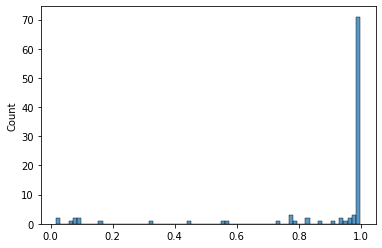

[0.0037268430460244417, 0.0012994027929380536, 0.0012998947640880942, 0.0013027144595980644, 0.1271486133337021, 0.0012960260501131415, 0.0013360469602048397, 0.0012966395588591695, 0.001297634094953537, 0.0013082704972475767, 0.0014030601596459746, 0.0013010683469474316, 0.0013103062519803643, 0.014979634433984756, 0.001298551564104855, 0.0012993431882932782, 0.001297808368690312, 0.0012983640190213919, 0.06269002705812454, 0.0012967927614226937, 0.06690430641174316, 0.001298496383242309, 0.0012966926442459226, 0.9407626986503601, 0.21181030571460724, 0.0013729806523770094, 0.0012985094217583537, 0.0012976712314411998, 0.0013069839915260673, 0.001316053792834282, 0.001298230024985969, 0.001302997930906713, 0.0013009858084842563, 0.0012986022047698498, 0.0013036857126280665, 0.0012964124325662851, 0.0013176880311220884, 0.00129616423510015, 0.001318227732554078, 0.0012971879914402962, 0.0013029153924435377, 0.007159879431128502, 0.0012969328090548515, 0.002089486690238118, 0.0012974932

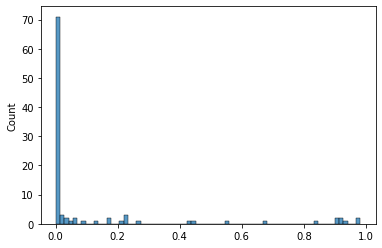

In [62]:
plot_scores('en-de')

Formal 0.75
InFormal 0.33


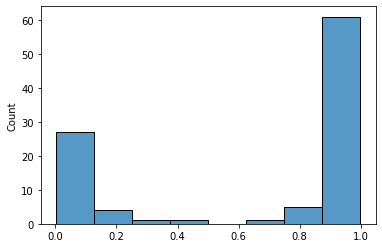

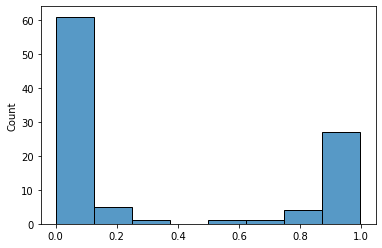

In [58]:
plot_scores('en-ja')

Formal 0.44
InFormal 0.6


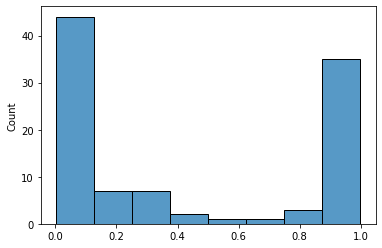

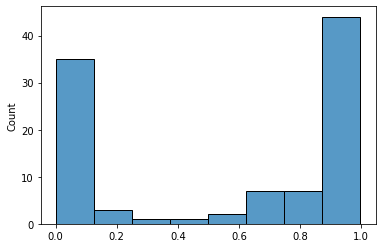

In [59]:
plot_scores('en-hi')

Formal 0.77
InFormal 0.24


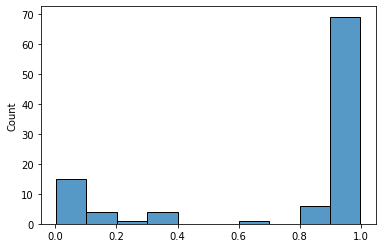

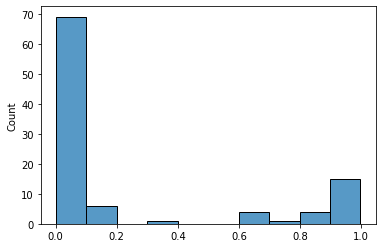

In [60]:
plot_scores('en-es')

Evaluate formality classifiers

In [10]:
formal = read_file("../../synthetic/de_en_formal.tsv")
informal = read_file("../../synthetic/de_en_informal.tsv")

In [11]:
model_dir="/fs/clip-controllablemt/IWSLT2022/models/xformal-classifier-de"
is_regression=False
cache_dir="/fs/clip-scratch/sweagraw/CACHE"

In [ ]:
formal_labels = []
for f in formal:
    formal_labels.append(classify(f))

In [ ]:
informal_labels = []
for f in informal:
    informal_labels.append(classify(f))

<AxesSubplot:ylabel='Count'>

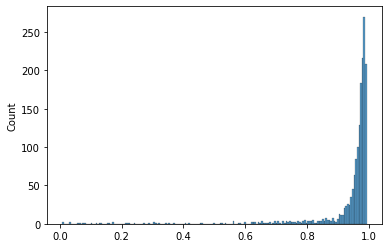

In [63]:
import seaborn as sns
import numpy as np
sns.histplot((1-np.array(formal_labels))[:, 0])

<AxesSubplot:ylabel='Count'>

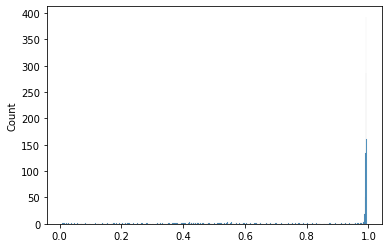

In [25]:
import seaborn as sns
import numpy as np
sns.histplot(np.array(informal_labels)[:, 0])